In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.cluster import DBSCAN

In [34]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import SaltRemover as sr
remover = sr.SaltRemover()

In [35]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [36]:
df1 = pd.read_csv('final_total.csv', sep=' ', na_values=['na'])
df1 = df1.dropna(ignore_index=True)
df1

,CHEMBLID,smiles,ido_ic50,tdo_ic50
0,CHEMBL1098875,O=C1c2cc(F)ccc2-n2c1nc1ccccc1c2=O,23.0,60.0
1,CHEMBL1209728,Cc1c(Br)oc2c1C(=O)C(=O)c1c-2ccc2c1CCCC2(C)C,10000.0,10000.0
2,CHEMBL1276265,O=C1c2ccc(Cl)cc2-n2c1nc1ccccc1c2=O,183.0,224200.0
3,CHEMBL1346056,Oc1ccccc1-c1nc2c3ccccc3c3ccccc3c2[nH]1,11790.0,12250.0
4,CHEMBL139935,O=[N+]([O-])c1cc(F)c2cccnc2c1O,14610.0,30230.0
...,...,...,...,...
755,CHEMBL5221020,O[C@@H]1CCCC[C@H]1CNc1c(Br)ccc2[nH]ncc12,1230.0,11240.0
756,CHEMBL5221102,Brc1cc(NC[C@H]2CCCN2)c2cn[nH]c2c1,56450.0,7450.0
757,CHEMBL578036,CC1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(CO)coc2-1,10000.0,450.0
758,CHEMBL584991,Nc1nonc1/C(=N/O)Nc1ccc(F)c(Cl)c1,50.0,10000.0


In [37]:
df1.loc[:, 'ido_ic50'] = (np.log10((df1.loc[:, 'ido_ic50'])*10**(-9)))*(-1)
df1.loc[:, 'tdo_ic50'] = (np.log10((df1.loc[:, 'tdo_ic50'])*10**(-9)))*(-1)

In [38]:
df2 = df1.loc[:, ['ido_ic50', 'tdo_ic50']]
df2

,ido_ic50,tdo_ic50
0,7.638272,7.221849
1,5.000000,5.000000
2,6.737549,3.649364
3,4.928486,4.911864
4,4.835350,4.519562
...,...,...
755,5.910095,4.949234
756,4.248336,5.127844
757,5.000000,6.346787
758,7.301030,5.000000


In [39]:
for i in range(len(df2)):
    if df2['ido_ic50'].values[i] >= 6.15:
        df2.loc[i, ['ido_ic50']] = 1
    else:
        df2.loc[i, ['ido_ic50']] = 0

In [40]:
for i in range(len(df2)):
    if df2['tdo_ic50'].values[i] >= 6.0:
        df2.loc[i, ['tdo_ic50']] = 1
    else:
        df2.loc[i, ['tdo_ic50']] = 0

In [41]:
df2

,ido_ic50,tdo_ic50
0,1.0,1.0
1,0.0,0.0
2,1.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
755,0.0,0.0
756,0.0,0.0
757,0.0,1.0
758,1.0,0.0


In [42]:
newcol = []
for i in range(len(df2)):
    if df2['ido_ic50'].values[i] == 1.0 and df2['tdo_ic50'].values[i] == 1.0:
        newcol.append('AA')
    elif df2['ido_ic50'].values[i] == 0.0 and df2['tdo_ic50'].values[i] == 0.0:
        newcol.append('II')
    elif df2['ido_ic50'].values[i] == 0.0 and df2['tdo_ic50'].values[i] == 1.0:
        newcol.append('IA')
    else:
        newcol.append('AI')

In [43]:
target = pd.DataFrame(data=newcol, columns=['ido_tdo'])
target

,ido_tdo
0,AA
1,II
2,AI
3,II
4,II
...,...
755,II
756,II
757,IA
758,AI


In [44]:
encoder = LabelEncoder()
y_label = encoder.fit_transform(target['ido_tdo'])

In [45]:
y_label

array([0, 3, 1, 3, 3, 3, 2, 3, 3, 3, 2, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1,
       3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 0, 2, 3, 3, 1, 2, 1, 2, 3, 3, 2, 3,
       3, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 3, 1, 3, 3, 3, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 0, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1,
       3, 1, 1, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 1, 3, 0, 0,
       1, 3, 0, 2, 1, 3, 3, 1, 0, 1, 0, 0, 0, 0, 1, 3, 1, 0, 0, 0, 1, 0,
       3, 1, 0, 0, 1, 0, 2, 0, 0, 0, 1, 0, 0, 1, 1, 3, 0, 0, 3, 0, 0, 3,
       0, 1, 2, 1, 0, 0, 0, 0, 2, 2, 1, 0, 1, 0, 3, 0, 0, 0, 0, 0, 3, 0,
       0, 1, 1, 2, 0, 0, 0, 1, 0, 0, 3, 1, 1, 2, 0, 3, 3, 0, 0, 3, 0, 3,
       0, 3, 3, 3, 0, 0, 0, 1, 1, 1, 1, 0, 2, 0, 3, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 3, 0, 3, 3, 3, 2, 2, 0, 1, 0, 2, 3, 0, 0, 1, 0, 0, 0,
       3, 3, 0, 0, 3, 3, 1, 2, 3, 0, 3, 0, 2, 0, 1, 3, 1, 0, 0, 3, 3, 0,
       0, 2, 1, 0, 3, 0, 3, 3, 0, 3, 3, 1, 1, 3, 3,

In [46]:
mols = []
for i in range(len(df1)):
    try:
        mol_i = Chem.MolFromSmiles(df1['smiles'][i])
        if mol_i is None:
            print(f"[WARNING] Invalid SMILES at index {i}, skipping.")
            mols.append(None)  # Maintain indexing for multiprocessing
            continue
        mol_i = remover.StripMol(mol_i, dontRemoveEverything=True)
        mols.append(mol_i)
    except Exception as e:
        print(e)
len(mols)

760

In [47]:
#Morgan Fingerprints:
fpgen2 = AllChem.GetMorganGenerator(fpSize=1024)
i = 0
l2 = np.zeros((1, 1024), dtype='uint8')
for mol in mols:
    fp2 = fpgen2.GetFingerprintAsNumPy(mols[i])
    l2 = np.vstack((l2, fp2))
    i += 1
MFPs = l2[1:, :]
MFPs.shape

(760, 1024)

In [48]:
FP_df = pd.DataFrame(MFPs)
FP_df

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
756,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
757,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
758,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
x = FP_df.values

In [50]:
from sklearn.decomposition import PCA

In [51]:
from sklearn.manifold import TSNE

In [52]:
tsne = TSNE(n_components=2, random_state=42)

In [53]:
reduced_data_tsne = tsne.fit_transform(x)

In [54]:
reduced_data_pca = PCA(n_components=2, random_state=42).fit_transform(x)

In [55]:
reduced_data_pca.shape

(760, 2)

In [56]:
#while DBSCAN provides a default value for eps parameter, 
#it hardly has a proper default value and must be tuned for the specific dataset at use.

In [64]:
#For sparse data and less dense data such as IDO_TDO, eps should be a high value,
# and min_samples should be low value.
db = DBSCAN(eps=5.0, min_samples=10).fit(reduced_data_tsne)
labels = db.labels_
len(labels)

760

In [65]:
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [59]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 13
Estimated number of noise points: 0


In [60]:
metrics.silhouette_score(reduced_data_tsne, labels)

0.48481855

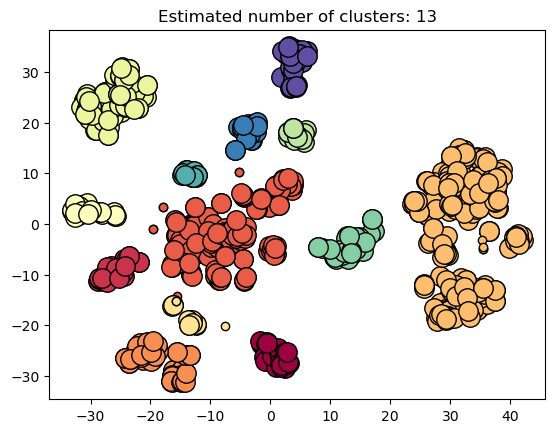

In [61]:
reduced_data = reduced_data_tsne
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = reduced_data[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = reduced_data[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()